# ***Title:- Low bit-width quantization scheme for LSTM inference which gives predictable degradation for ASR (Automatic Speech Recognition) models.***

# **Step 1: Setup (Import Libraries)**

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
print(tf.version.VERSION)
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2.8.2


# **Step 2:- Import the Google Speech Commands dataset**



In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

***## Moving wav files from command directories to unknown sub-directory (Factory Reset to reset data directory)***




In [ ]:
# comment out below line if "unknown" directory already exists
!mkdir /content/data/mini_speech_commands/unknown
# moves files from their specific commands directory to the "unknown" directory (replaces all files with an existing name therefore example set is smaller)
!mv /content/data/mini_speech_commands/down/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/down
!mv /content/data/mini_speech_commands/go/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/go
!mv /content/data/mini_speech_commands/left/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/left
!mv /content/data/mini_speech_commands/right/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/right
!mv /content/data/mini_speech_commands/stop/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/stop
!mv /content/data/mini_speech_commands/up/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/up
!rm /content/data/mini_speech_commands/README.md
!ls /content/data/mini_speech_commands/unknown | wc -l

mkdir: cannot create directory ‘/content/data/mini_speech_commands/unknown’: File exists
mv: cannot stat '/content/data/mini_speech_commands/down/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/down': No such file or directory
mv: cannot stat '/content/data/mini_speech_commands/go/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/go': No such file or directory
mv: cannot stat '/content/data/mini_speech_commands/left/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/left': No such file or directory
mv: cannot stat '/content/data/mini_speech_commands/right/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/right': No such file or directory
mv: cannot stat '/content/data/mini_speech_commands/stop/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/stop': No such file or directory
mv: cannot stat '/content/data/mini_speech_

***## Sets wanted commands for training (Available commands: Down, Go, Left, No, Right, Stop, Up, Yes, and Unknown for commands that are not to be tested***

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = ["yes","no", "unknown"]
print('Commands:', commands)

Commands: ['yes', 'no', 'unknown']


***## Extract the audio files into a list and shuffle it.***

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 5311
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/yes/e7334395_nohash_2.wav', shape=(), dtype=string)


# **Step 3:- Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.**

In [ ]:
# Take 80% of total number examples for training set files
train_files = filenames[:4249]
# Take 10% of total number examples adding to 80% of total examples for validation set files
val_files = filenames[4249: 4249 + 531]
# Take -10% of total number examples for test set files
test_files = filenames[-531:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 4249
Validation set size 531
Test set size 531


# **Step 4:- Reading audio files and their labels**

***## The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.***

***## To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.***

***## A WAV file contains time series data with a set number of samples per second.Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767.***

***## The sample rate for this dataset is 16kHz. Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0]. ***

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

**## The label for each WAV file is its parent directory.**

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

**## Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.**

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

***## Let's examine a few audio waveforms with their corresponding labels.***

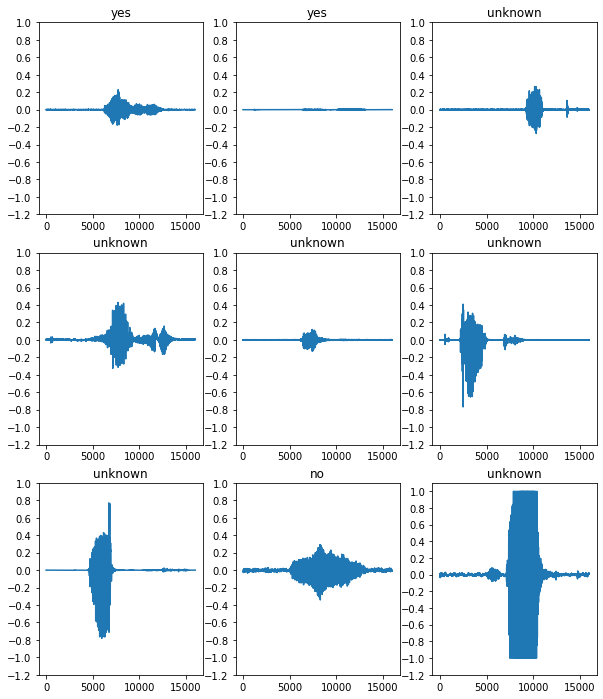

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

# **Step 5:- Spectrogram**

***## We converted the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.***

 ***## A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.***

***## STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`.***


***## We can Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, we can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing.***

***## We also want the waveforms to have the same length, so that when we convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.***

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=480, frame_step=320, fft_length=512)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

***## Next, we will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.***

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (49, 257)
Audio playback


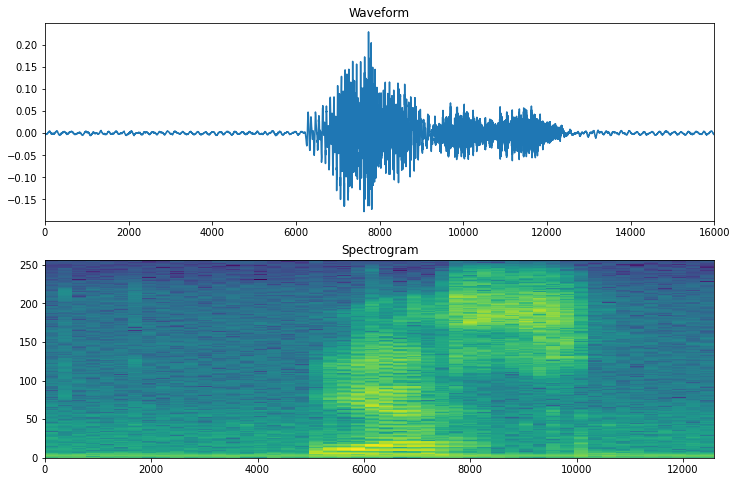

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

***## Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.***

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


***## Examine the spectrogram "images" for different samples of the dataset.***

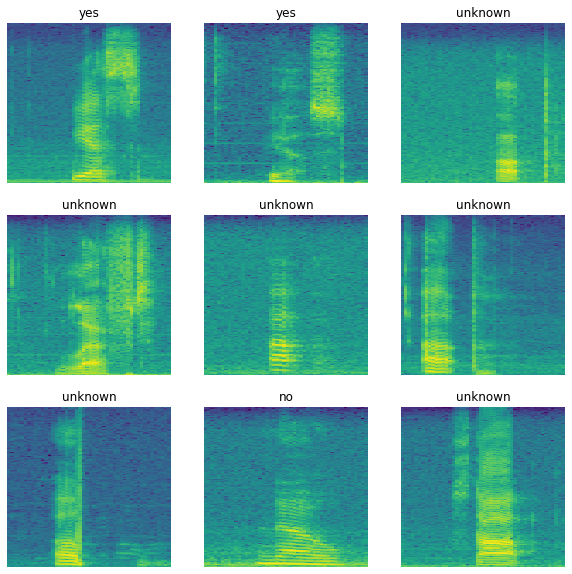

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# **Step:-6 Build and train the model**

***## Now we can build and train our model. But before we do that, we'll need to repeat the training set preprocessing on the validation and test sets.***

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
print(val_ds)
print(test_ds)


<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


***## Batch the training and validation sets for model training.***

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

***## Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.***

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

***## For the model, we'll use a simple LSTM network, since we have transformed the audio files into spectrogram images.***

***## The model also has the following additional preprocessing layers:***
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

***## For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).***

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print('num_labels:', num_labels)

model = models.Sequential([
    layers.Input(shape=(49, 257), name='input'),
    layers.Reshape(target_shape=(49, 257)),
    layers.LSTM(80, time_major=False, return_sequences=True),
    layers.Flatten(),
    layers.Dense(3, activation=tf.nn.softmax, name='output')
])
model.summary()


Input shape: (49, 257, 1)
num_labels: 3
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 49, 257)           0         
                                                                 
 lstm_1 (LSTM)               (None, 49, 80)            108160    
                                                                 
 flatten_1 (Flatten)         (None, 3920)              0         
                                                                 
 output (Dense)              (None, 3)                 11763     
                                                                 
Total params: 119,923
Trainable params: 119,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import numpy as np
s_len = 49 * 257 * 1
s = np.arange(s_len).reshape(input_shape)
print(s.shape)
print(s)
s.dtype

(49, 257, 1)
[[[    0]
  [    1]
  [    2]
  ...
  [  254]
  [  255]
  [  256]]

 [[  257]
  [  258]
  [  259]
  ...
  [  511]
  [  512]
  [  513]]

 [[  514]
  [  515]
  [  516]
  ...
  [  768]
  [  769]
  [  770]]

 ...

 [[11822]
  [11823]
  [11824]
  ...
  [12076]
  [12077]
  [12078]]

 [[12079]
  [12080]
  [12081]
  ...
  [12333]
  [12334]
  [12335]]

 [[12336]
  [12337]
  [12338]
  ...
  [12590]
  [12591]
  [12592]]]


dtype('int64')

***## Loss function and Optimizer used***

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

***## Model fit***

In [ ]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
   # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
67/67 [==============================] - 15s 132ms/step - loss: 0.5539 - accuracy: 0.7764 - val_loss: 0.4418 - val_accuracy: 0.8286
Epoch 2/100
67/67 [==============================] - 1s 7ms/step - loss: 0.3205 - accuracy: 0.8816 - val_loss: 0.3647 - val_accuracy: 0.8569
Epoch 3/100
67/67 [==============================] - 0s 6ms/step - loss: 0.2220 - accuracy: 0.9193 - val_loss: 0.3518 - val_accuracy: 0.8682
Epoch 4/100
67/67 [==============================] - 0s 6ms/step - loss: 0.1581 - accuracy: 0.9435 - val_loss: 0.3542 - val_accuracy: 0.8795
Epoch 5/100
67/67 [==============================] - 0s 6ms/step - loss: 0.1335 - accuracy: 0.9487 - val_loss: 0.3554 - val_accuracy: 0.9040
Epoch 6/100
67/67 [==============================] - 0s 7ms/step - loss: 0.1162 - accuracy: 0.9567 - val_loss: 0.4713 - val_accuracy: 0.8719
Epoch 7/100
67/67 [==============================] - 0s 6ms/step - loss: 0.1158 - accuracy: 0.9527 - val_loss: 0.3944 - val_accuracy: 0.8795
Epoch 8/10

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

In [ ]:
print("Model:")

Model:


***## Let's check the training and validation loss & accuracy-val_accuracy curves to see how our model has improved during training.***

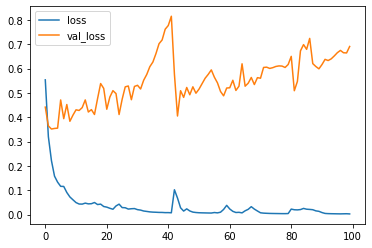

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# **Step 7:- Evaluate test set performance**

***## Let's run the model on the test set and check performance.***

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 94%


# **Step 8:- Display a confusion matrix**

***## A confusion matrix is helpful to see how well the model did on each of the commands in the test set.***

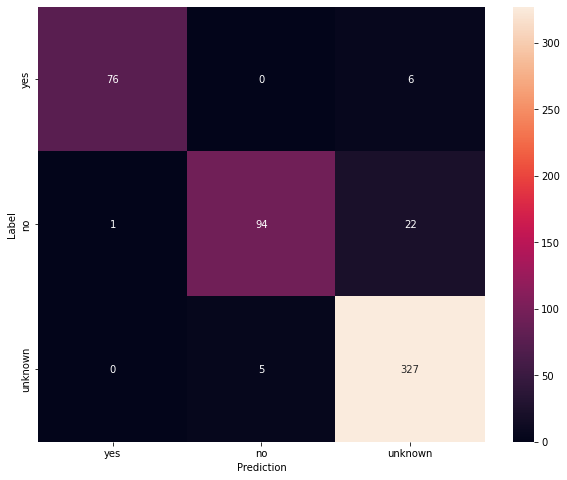

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# **Step 9:- Run inference on an audio file**

***## Finally, verify the model's prediction output using an input audio file of someone saying "yes." How well does your model perform?***

3
tf.Tensor([0.57611686 0.21194157 0.21194157], shape=(3,), dtype=float32)
tf.Tensor([[0.57611686 0.21194157 0.21194157]], shape=(1, 3), dtype=float32)


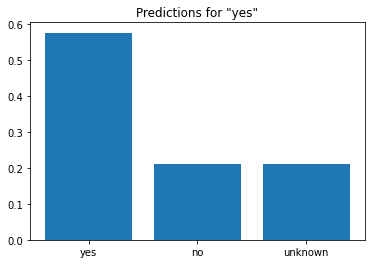

In [ ]:
sample_file = '/content/data/mini_speech_commands/yes/0132a06d_nohash_1.wav'

sample_ds = preprocess_dataset([str(sample_file)])
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  print(len(commands))
  print(tf.nn.softmax(prediction[0]))
  print(tf.nn.softmax(prediction))
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

***--We can see that your model very clearly recognized the audio command as "yes."***

In [ ]:
model.save("./saved_model.h5/")

# **Step 10:- Run TF (Tensorflow) inference on multiple audio files**

/content/data/mini_speech_commands/unknown/6794a793_nohash_0.wav


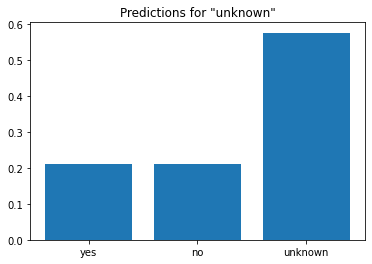

/content/data/mini_speech_commands/unknown/7e1054e7_nohash_1.wav


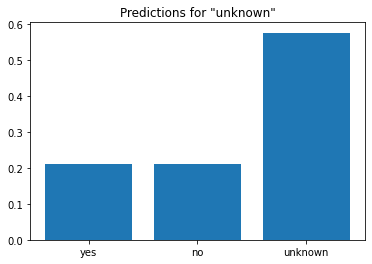

/content/data/mini_speech_commands/unknown/e0611c84_nohash_0.wav


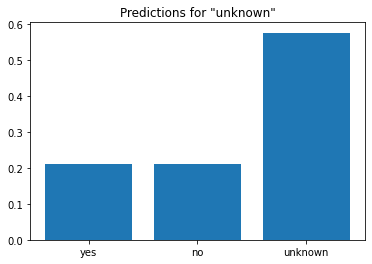

/content/data/mini_speech_commands/unknown/c8771f88_nohash_0.wav


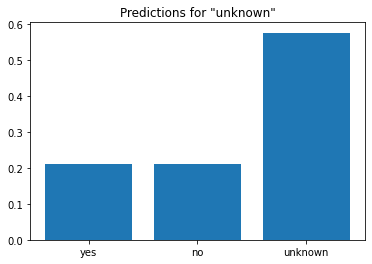

/content/data/mini_speech_commands/unknown/2bfe70ef_nohash_0.wav


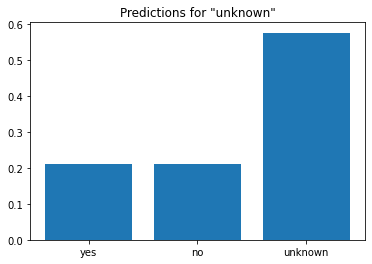

/content/data/mini_speech_commands/unknown/6c0f6493_nohash_4.wav


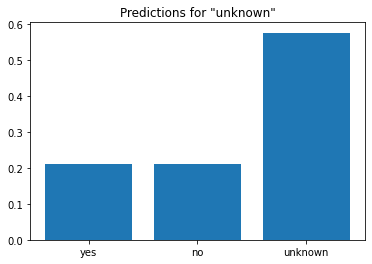

/content/data/mini_speech_commands/unknown/cc6bae0d_nohash_1.wav


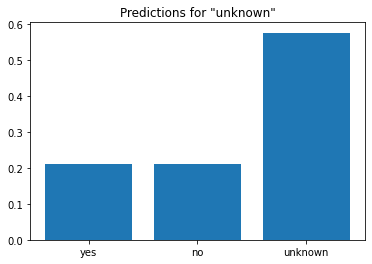

/content/data/mini_speech_commands/unknown/037c445a_nohash_0.wav


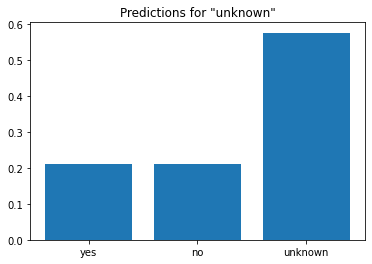

/content/data/mini_speech_commands/unknown/3209ec42_nohash_1.wav


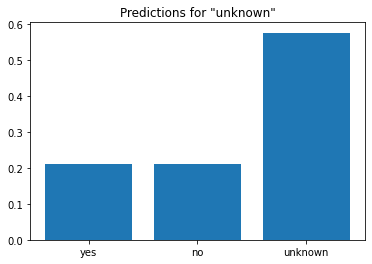

/content/data/mini_speech_commands/unknown/71904de3_nohash_0.wav


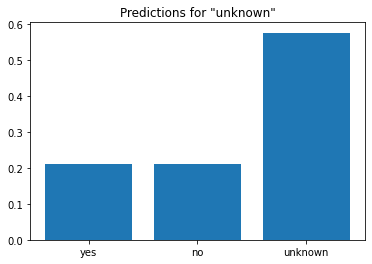

/content/data/mini_speech_commands/unknown/38d78313_nohash_2.wav


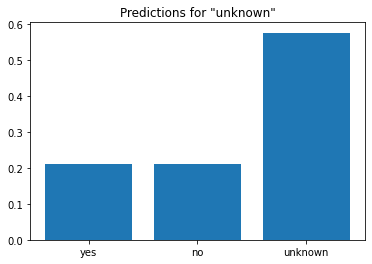

/content/data/mini_speech_commands/unknown/070b49af_nohash_0.wav


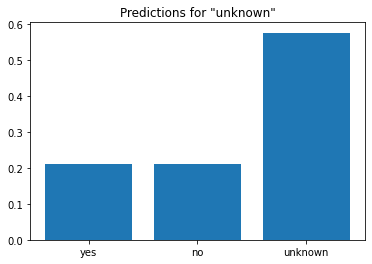

/content/data/mini_speech_commands/unknown/5fadb538_nohash_3.wav


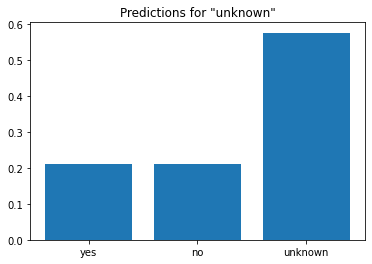

/content/data/mini_speech_commands/unknown/fa446c16_nohash_1.wav


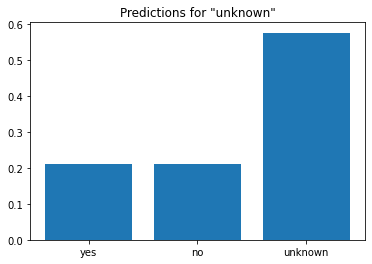

/content/data/mini_speech_commands/unknown/ae927455_nohash_3.wav


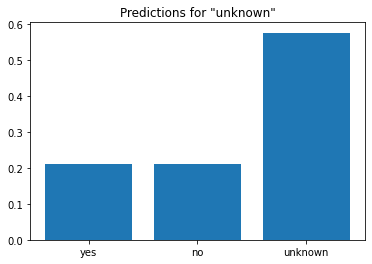

/content/data/mini_speech_commands/unknown/5de3f6cc_nohash_0.wav


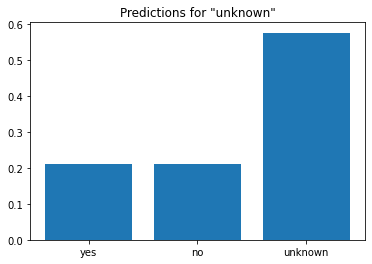

/content/data/mini_speech_commands/unknown/837f7378_nohash_0.wav


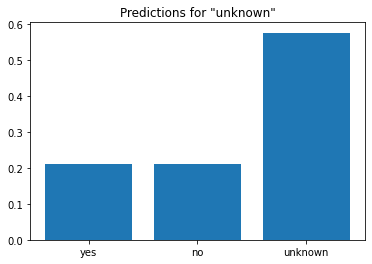

/content/data/mini_speech_commands/unknown/31267b59_nohash_0.wav


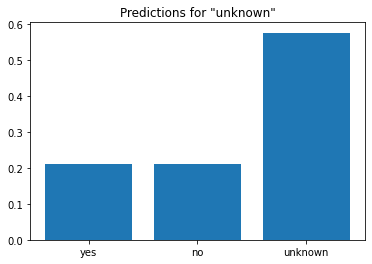

/content/data/mini_speech_commands/unknown/7a5530c9_nohash_1.wav


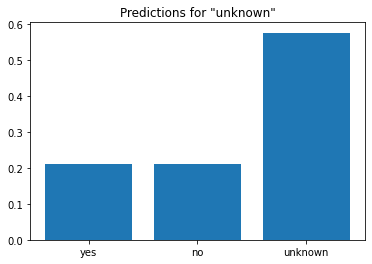

/content/data/mini_speech_commands/unknown/e4b02540_nohash_0.wav


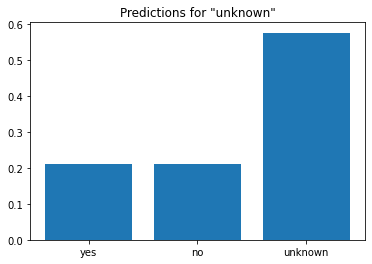

/content/data/mini_speech_commands/unknown/82c6d220_nohash_1.wav


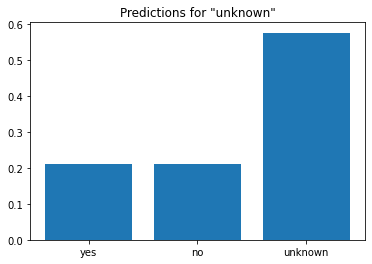

/content/data/mini_speech_commands/unknown/8c7b691a_nohash_0.wav


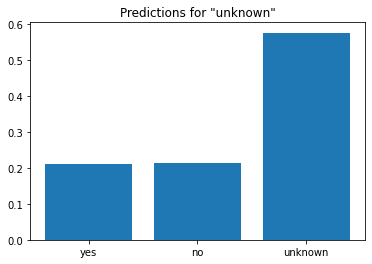

/content/data/mini_speech_commands/unknown/6727b579_nohash_2.wav


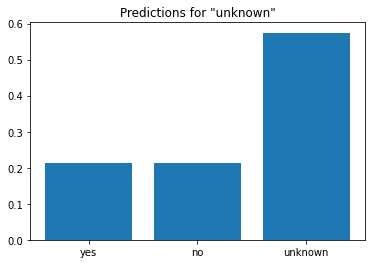

/content/data/mini_speech_commands/unknown/8b39e36f_nohash_1.wav


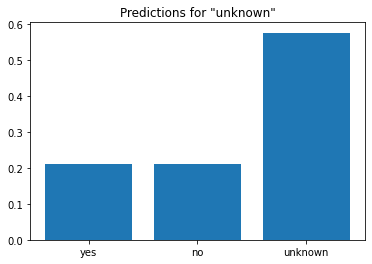

/content/data/mini_speech_commands/unknown/eb0676ec_nohash_0.wav


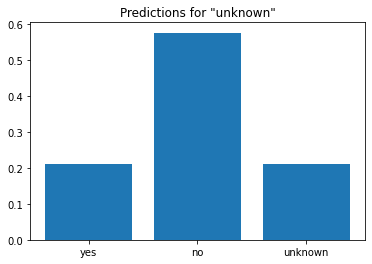

In [ ]:
import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/unknown/*.wav"):
    txtfiles.append(file)

for i in range(25):
  print(txtfiles[i])
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

# ***Step 11:- Trained model weights visualizations layerwise***

***Step 11.1:- Weights for Layer [0]***

In [ ]:
model.get_weights()[0]




array([[ 0.07494675,  0.03912783, -0.02228122, ...,  0.06316861,
        -0.08789887,  0.05863257],
       [ 0.09791417,  0.04359267, -0.13420914, ...,  0.02945278,
        -0.06535106, -0.05318328],
       [-0.01138164,  0.01260689, -0.09285012, ...,  0.17173903,
         0.13254495, -0.18717386],
       ...,
       [ 0.17602918, -0.16493158, -0.04272654, ..., -0.19131006,
        -0.00866026,  0.02560443],
       [ 0.11876293, -0.06680916, -0.05857946, ..., -0.24740016,
         0.03912716, -0.01557422],
       [ 0.14850059, -0.12527737,  0.00428717, ..., -0.24339913,
        -0.05492501, -0.0792207 ]], dtype=float32)

***Step 11.2:- Weights for Layer [1]***

In [ ]:
model.get_weights()[1]

array([[-0.06080294,  0.11674429,  0.00677274, ..., -0.01825441,
         0.23747472,  0.03532412],
       [-0.02085792,  0.03370494,  0.17107809, ...,  0.10651273,
         0.1016257 , -0.03583364],
       [ 0.13742787, -0.06362658,  0.12782261, ..., -0.07405598,
         0.31147316, -0.00242772],
       ...,
       [-0.20358603,  0.06468102, -0.2748718 , ...,  0.03596471,
        -0.01105351, -0.02000266],
       [-0.00906198,  0.16464339,  0.07520864, ...,  0.0103049 ,
         0.1229859 ,  0.17122254],
       [ 0.17378385,  0.17337933,  0.03175817, ...,  0.13805214,
        -0.12137617, -0.02062947]], dtype=float32)

***Step 11.3:- Weights for Layer [2]***

In [ ]:
model.get_weights()[2]

array([-4.97249514e-03, -5.02500571e-02, -9.13476422e-02, -4.30004001e-02,
       -6.92659756e-03,  1.20815299e-02, -2.40374431e-02, -1.58335984e-01,
       -6.30542785e-02,  1.04762889e-01, -1.26684800e-01,  8.14979747e-02,
        7.18823597e-02, -1.37591943e-01,  3.73544032e-03,  2.92371958e-02,
       -6.70067966e-02,  5.19426055e-02, -8.86380002e-02, -6.02260605e-02,
       -8.60294625e-02, -1.26065966e-02,  6.27078861e-02,  1.29610067e-02,
       -8.79516602e-02,  3.18972319e-02, -7.69281685e-02,  7.70414099e-02,
       -2.63044089e-02, -1.40209436e-01, -5.39996810e-02,  4.57578562e-02,
       -4.45864201e-02, -7.54076317e-02, -4.10037488e-02,  1.04395403e-02,
       -3.62885557e-02, -9.86084342e-02, -2.05228515e-02, -7.09173828e-02,
        3.10520716e-02, -4.86839488e-02,  1.09129094e-01, -1.20437471e-02,
       -3.94521989e-02,  1.50974840e-01, -2.86302455e-02, -1.08288871e-02,
        2.98524015e-02, -9.37893465e-02,  1.62864234e-02, -1.01181552e-01,
       -1.42770872e-01, -

***Step 11.4:- Weights for Layer [3]***

In [ ]:
model.get_weights()[3]

array([[ 0.08048522,  0.00823719, -0.05111016],
       [-0.14663814, -0.05994761,  0.13583085],
       [-0.08719911, -0.02458129,  0.08829708],
       ...,
       [-0.22080986,  0.01297371,  0.0588188 ],
       [ 0.07233882, -0.01199459,  0.00556055],
       [-0.03929587, -0.05739682,  0.0569095 ]], dtype=float32)

# ***Step 12:- Apply Affine quantization scheme on Trained model weights layer by layer***

In [ ]:
import numpy as np
Input_shape = (49, 257)
s_len = 49 * 257
s = np.arange(s_len).reshape(Input_shape)
print(s.shape)
print(s)
s.dtype

(49, 257)
[[    0     1     2 ...   254   255   256]
 [  257   258   259 ...   511   512   513]
 [  514   515   516 ...   768   769   770]
 ...
 [11822 11823 11824 ... 12076 12077 12078]
 [12079 12080 12081 ... 12333 12334 12335]
 [12336 12337 12338 ... 12590 12591 12592]]


dtype('int64')

In [ ]:
# Min-Max value of float_32 tensor (x) find out for scale (s) and zero point (z)

b0 = np.amax(s)
print(b0)

12592


In [ ]:
# Min-Max value of float_32 tensor (x) find out for scale (s) and zero point (z)

b0 = np.amax(s)
print(b0)

12592


In [ ]:
a0 = np.amin(s)
print(a0)

0


In [ ]:
# scale value

scale0 = (b0-a0)/15

print(scale0)

839.4666666666667


In [ ]:
# zero point

zero_point0 = np.round(-a0*15/(b0-a0))

print(zero_point0)

0.0


In [ ]:
f0 = np.round(s/scale0 + zero_point0)
print(f0)
s0q = np.clip(f0, a_min=0, a_max=15) # Here min & max value we can change as per Tbit.
# But, I have checked for 4 bit
print (s0q)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [14. 14. 14. ... 14. 14. 14.]
 [14. 14. 14. ... 15. 15. 15.]
 [15. 15. 15. ... 15. 15. 15.]]
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [14. 14. 14. ... 14. 14. 14.]
 [14. 14. 14. ... 15. 15. 15.]
 [15. 15. 15. ... 15. 15. 15.]]


### ***Step 12.1:- Quantization apply on Weights for Layer [0]***

In [ ]:
T0 = np.array (model.get_weights()[0])
print(T0)
print(T0.shape)


[[ 0.07494675  0.03912783 -0.02228122 ...  0.06316861 -0.08789887
   0.05863257]
 [ 0.09791417  0.04359267 -0.13420914 ...  0.02945278 -0.06535106
  -0.05318328]
 [-0.01138164  0.01260689 -0.09285012 ...  0.17173903  0.13254495
  -0.18717386]
 ...
 [ 0.17602918 -0.16493158 -0.04272654 ... -0.19131006 -0.00866026
   0.02560443]
 [ 0.11876293 -0.06680916 -0.05857946 ... -0.24740016  0.03912716
  -0.01557422]
 [ 0.14850059 -0.12527737  0.00428717 ... -0.24339913 -0.05492501
  -0.0792207 ]]
(257, 320)


In [ ]:
# Min-Max value of float_32 tensor (x) find out for scale (s) and zero point (z)

b0 = np.amax(T0)
print(b0)

0.6752613


In [ ]:
a0 = np.amin(T0)
print(a0)

-0.56484795


In [ ]:
# scale value

scale0 = (b0-a0)/15

print(scale0)

0.08267394701639812


In [ ]:
# zero point

zero_point0 = np.round(-a0*15/(b0-a0))

print(zero_point0)

7.0


In [ ]:
f0 = np.round(T0/scale0 + zero_point0)
print(f0)
T0q = np.clip(f0, a_min=0, a_max=15) # Here min & max value we can change as per Tbit.
# But, I have checked for 16 bit
print (T0q)

[[8. 7. 7. ... 8. 6. 8.]
 [8. 8. 5. ... 7. 6. 6.]
 [7. 7. 6. ... 9. 9. 5.]
 ...
 [9. 5. 6. ... 5. 7. 7.]
 [8. 6. 6. ... 4. 7. 7.]
 [9. 5. 7. ... 4. 6. 6.]]
[[8. 7. 7. ... 8. 6. 8.]
 [8. 8. 5. ... 7. 6. 6.]
 [7. 7. 6. ... 9. 9. 5.]
 ...
 [9. 5. 6. ... 5. 7. 7.]
 [8. 6. 6. ... 4. 7. 7.]
 [9. 5. 7. ... 4. 6. 6.]]


In [ ]:
j = tf.matmul(s0q, T0q)
print(j)

tf.Tensor(
[[    0.     0.     0. ...     0.     0.     0.]
 [  650.   692.   633. ...   544.   570.   691.]
 [ 1760.  1840.  1895. ...  1701.  1791.  1830.]
 ...
 [24640. 25760. 26530. ... 23814. 25074. 25620.]
 [25711. 26906. 27728. ... 24811. 26142. 26751.]
 [26400. 27600. 28425. ... 25515. 26865. 27450.]], shape=(49, 320), dtype=float64)


In [ ]:
T0dq = scale0*(T0q - zero_point0)
print(T0dq)

[[ 0.07495342  0.03913246 -0.0222722  ...  0.06316449 -0.08789666
   0.05864193]
 [ 0.09790685  0.04359826 -0.13420089 ...  0.02944396 -0.06535954
  -0.05319214]
 [-0.01137264  0.01260262 -0.09285445 ...  0.17174383  0.13253567
  -0.18716595]
 ...
 [ 0.17602038 -0.1649316  -0.04272781 ... -0.19131005 -0.00866667
   0.02560262]
 [ 0.11875983 -0.0668166  -0.05858516 ... -0.2473974   0.03913246
  -0.01557351]
 [ 0.14850655 -0.1252693   0.00429549 ... -0.24340467 -0.05493305
  -0.07922999]]


In [ ]:
# print input and target tensors
print("Input Tensor:\n", T0)
print("Target Tensor:\n", T0dq)
mse = tf.keras.losses.MeanAbsoluteError()
mse(T0dq, T0).numpy()

Input Tensor:
 [[ 0.07494675  0.03912783 -0.02228122 ...  0.06316861 -0.08789887
   0.05863257]
 [ 0.09791417  0.04359267 -0.13420914 ...  0.02945278 -0.06535106
  -0.05318328]
 [-0.01138164  0.01260689 -0.09285012 ...  0.17173903  0.13254495
  -0.18717386]
 ...
 [ 0.17602918 -0.16493158 -0.04272654 ... -0.19131006 -0.00866026
   0.02560443]
 [ 0.11876293 -0.06680916 -0.05857946 ... -0.24740016  0.03912716
  -0.01557422]
 [ 0.14850059 -0.12527737  0.00428717 ... -0.24339913 -0.05492501
  -0.0792207 ]]
Target Tensor:
 [[ 0.07495342  0.03913246 -0.0222722  ...  0.06316449 -0.08789666
   0.05864193]
 [ 0.09790685  0.04359826 -0.13420089 ...  0.02944396 -0.06535954
  -0.05319214]
 [-0.01137264  0.01260262 -0.09285445 ...  0.17174383  0.13253567
  -0.18716595]
 ...
 [ 0.17602038 -0.1649316  -0.04272781 ... -0.19131005 -0.00866667
   0.02560262]
 [ 0.11875983 -0.0668166  -0.05858516 ... -0.2473974   0.03913246
  -0.01557351]
 [ 0.14850655 -0.1252693   0.00429549 ... -0.24340467 -0.05493305
 

4.733479e-06

In [ ]:
# print input and target tensors
print("Input Tensor:\n", T0)
print("Target Tensor:\n", T0dq)
mse = tf.keras.losses.MeanSquaredError()
mse(T0dq, T0).numpy()

Input Tensor:
 [[ 0.07494675  0.03912783 -0.02228122 ...  0.06316861 -0.08789887
   0.05863257]
 [ 0.09791417  0.04359267 -0.13420914 ...  0.02945278 -0.06535106
  -0.05318328]
 [-0.01138164  0.01260689 -0.09285012 ...  0.17173903  0.13254495
  -0.18717386]
 ...
 [ 0.17602918 -0.16493158 -0.04272654 ... -0.19131006 -0.00866026
   0.02560443]
 [ 0.11876293 -0.06680916 -0.05857946 ... -0.24740016  0.03912716
  -0.01557422]
 [ 0.14850059 -0.12527737  0.00428717 ... -0.24339913 -0.05492501
  -0.0792207 ]]
Target Tensor:
 [[ 0.07495342  0.03913246 -0.0222722  ...  0.06316449 -0.08789666
   0.05864193]
 [ 0.09790685  0.04359826 -0.13420089 ...  0.02944396 -0.06535954
  -0.05319214]
 [-0.01137264  0.01260262 -0.09285445 ...  0.17174383  0.13253567
  -0.18716595]
 ...
 [ 0.17602038 -0.1649316  -0.04272781 ... -0.19131005 -0.00866667
   0.02560262]
 [ 0.11875983 -0.0668166  -0.05858516 ... -0.2473974   0.03913246
  -0.01557351]
 [ 0.14850655 -0.1252693   0.00429549 ... -0.24340467 -0.05493305
 

2.9896266e-11

### ***Step 12.2:- Quantization apply on Weights for Layer [1]***

In [ ]:
T1 = np.array (model.get_weights()[1])
print(T1)
print(T1.shape)


[[-0.06080294  0.11674429  0.00677274 ... -0.01825441  0.23747472
   0.03532412]
 [-0.02085792  0.03370494  0.17107809 ...  0.10651273  0.1016257
  -0.03583364]
 [ 0.13742787 -0.06362658  0.12782261 ... -0.07405598  0.31147316
  -0.00242772]
 ...
 [-0.20358603  0.06468102 -0.2748718  ...  0.03596471 -0.01105351
  -0.02000266]
 [-0.00906198  0.16464339  0.07520864 ...  0.0103049   0.1229859
   0.17122254]
 [ 0.17378385  0.17337933  0.03175817 ...  0.13805214 -0.12137617
  -0.02062947]]
(80, 320)


In [ ]:
# Min-Max value of float_32 tensor (x) find out for scale (s) and zero point (z)

b1 = np.amax(T1)
print(b1)

0.49867725


In [ ]:
a1 = np.amin(T1)
print(a1)

-0.5685387


In [ ]:
# scale value

scale1 = (b1-a1)/65535

print(scale1)

1.6284671084071548e-05


In [ ]:
# zero point

zero_point1 = np.round(-a1*65535/(b1-a1))

print(zero_point1)

34913.0


In [ ]:

f1 = np.round(T1/scale1 + zero_point1)
print(f1)
T1q = np.clip(f1, a_min=0, a_max=65535) # Here min & max value we can change as per Tbit.
# But, I have checked for 16 bit
print (T1q)

[[31179. 42082. 35329. ... 33792. 49496. 37082.]
 [33632. 36983. 45418. ... 41454. 41154. 32713.]
 [43352. 31006. 42762. ... 30365. 54040. 34764.]
 ...
 [22411. 38885. 18034. ... 37122. 34234. 33685.]
 [34357. 45023. 39531. ... 35546. 42465. 45427.]
 [45585. 45560. 36863. ... 43390. 27460. 33646.]]
[[31179. 42082. 35329. ... 33792. 49496. 37082.]
 [33632. 36983. 45418. ... 41454. 41154. 32713.]
 [43352. 31006. 42762. ... 30365. 54040. 34764.]
 ...
 [22411. 38885. 18034. ... 37122. 34234. 33685.]
 [34357. 45023. 39531. ... 35546. 42465. 45427.]
 [45585. 45560. 36863. ... 43390. 27460. 33646.]]


In [ ]:
T1dq = scale1*(T1q - zero_point1)
print(T1dq)

[[-0.06080696  0.11674481  0.00677442 ... -0.01825512  0.23747937
   0.03532145]
 [-0.02086066  0.03370927  0.17107047 ...  0.10651804  0.10163264
  -0.03582628]
 [ 0.13742635 -0.06362421  0.12781839 ... -0.07406269  0.31147692
  -0.00242642]
 ...
 [-0.20359097  0.06468271 -0.27486897 ...  0.03597284 -0.01105729
  -0.01999758]
 [-0.00905428  0.16463803  0.07520261 ...  0.0103082   0.12298184
   0.17121704]
 [ 0.17379002  0.17338291  0.03175511 ...  0.13804516 -0.12136966
  -0.02063268]]


In [ ]:
# print input and target tensors
print("Input Tensor:\n", T1)
print("Target Tensor:\n", T1dq)
mse = tf.keras.losses.MeanAbsoluteError()
mse(T1dq, T1).numpy()

Input Tensor:
 [[-0.06080294  0.11674429  0.00677274 ... -0.01825441  0.23747472
   0.03532412]
 [-0.02085792  0.03370494  0.17107809 ...  0.10651273  0.1016257
  -0.03583364]
 [ 0.13742787 -0.06362658  0.12782261 ... -0.07405598  0.31147316
  -0.00242772]
 ...
 [-0.20358603  0.06468102 -0.2748718  ...  0.03596471 -0.01105351
  -0.02000266]
 [-0.00906198  0.16464339  0.07520864 ...  0.0103049   0.1229859
   0.17122254]
 [ 0.17378385  0.17337933  0.03175817 ...  0.13805214 -0.12137617
  -0.02062947]]
Target Tensor:
 [[-0.06080696  0.11674481  0.00677442 ... -0.01825512  0.23747937
   0.03532145]
 [-0.02086066  0.03370927  0.17107047 ...  0.10651804  0.10163264
  -0.03582628]
 [ 0.13742635 -0.06362421  0.12781839 ... -0.07406269  0.31147692
  -0.00242642]
 ...
 [-0.20359097  0.06468271 -0.27486897 ...  0.03597284 -0.01105729
  -0.01999758]
 [-0.00905428  0.16463803  0.07520261 ...  0.0103082   0.12298184
   0.17121704]
 [ 0.17379002  0.17338291  0.03175511 ...  0.13804516 -0.12136966
  -

4.0951286e-06

In [ ]:
# print input and target tensors
print("Input Tensor:\n", T1)
print("Target Tensor:\n", T1dq)
mse = tf.keras.losses.MeanSquaredError()
mse(T1dq, T1).numpy()

Input Tensor:
 [[-0.06080294  0.11674429  0.00677274 ... -0.01825441  0.23747472
   0.03532412]
 [-0.02085792  0.03370494  0.17107809 ...  0.10651273  0.1016257
  -0.03583364]
 [ 0.13742787 -0.06362658  0.12782261 ... -0.07405598  0.31147316
  -0.00242772]
 ...
 [-0.20358603  0.06468102 -0.2748718  ...  0.03596471 -0.01105351
  -0.02000266]
 [-0.00906198  0.16464339  0.07520864 ...  0.0103049   0.1229859
   0.17122254]
 [ 0.17378385  0.17337933  0.03175817 ...  0.13805214 -0.12137617
  -0.02062947]]
Target Tensor:
 [[-0.06080696  0.11674481  0.00677442 ... -0.01825512  0.23747937
   0.03532145]
 [-0.02086066  0.03370927  0.17107047 ...  0.10651804  0.10163264
  -0.03582628]
 [ 0.13742635 -0.06362421  0.12781839 ... -0.07406269  0.31147692
  -0.00242642]
 ...
 [-0.20359097  0.06468271 -0.27486897 ...  0.03597284 -0.01105729
  -0.01999758]
 [-0.00905428  0.16463803  0.07520261 ...  0.0103082   0.12298184
   0.17121704]
 [ 0.17379002  0.17338291  0.03175511 ...  0.13804516 -0.12136966
  -

2.2280195e-11

### ***Step 12.3:- Quantization apply on Weights for Layer [2]***

In [ ]:
T2 = np.array (model.get_weights()[2])
print(T2)
print(T2.shape)


[-4.97249514e-03 -5.02500571e-02 -9.13476422e-02 -4.30004001e-02
 -6.92659756e-03  1.20815299e-02 -2.40374431e-02 -1.58335984e-01
 -6.30542785e-02  1.04762889e-01 -1.26684800e-01  8.14979747e-02
  7.18823597e-02 -1.37591943e-01  3.73544032e-03  2.92371958e-02
 -6.70067966e-02  5.19426055e-02 -8.86380002e-02 -6.02260605e-02
 -8.60294625e-02 -1.26065966e-02  6.27078861e-02  1.29610067e-02
 -8.79516602e-02  3.18972319e-02 -7.69281685e-02  7.70414099e-02
 -2.63044089e-02 -1.40209436e-01 -5.39996810e-02  4.57578562e-02
 -4.45864201e-02 -7.54076317e-02 -4.10037488e-02  1.04395403e-02
 -3.62885557e-02 -9.86084342e-02 -2.05228515e-02 -7.09173828e-02
  3.10520716e-02 -4.86839488e-02  1.09129094e-01 -1.20437471e-02
 -3.94521989e-02  1.50974840e-01 -2.86302455e-02 -1.08288871e-02
  2.98524015e-02 -9.37893465e-02  1.62864234e-02 -1.01181552e-01
 -1.42770872e-01 -4.55944315e-02 -8.23507085e-02  8.99611339e-02
  1.51275858e-01 -2.01641694e-02 -7.05610216e-02 -3.77879813e-02
  9.11203995e-02  5.54262

In [ ]:
# Min-Max value of float_32 tensor (x) find out for scale (s) and zero point (z)

b2 = np.amax(T2)
print(b2)

1.2047697


In [ ]:
a2 = np.amin(T2)
print(a2)

-0.15833598


In [ ]:
# scale value

scale2 = (b2-a2)/65535

print(scale2)

2.079966085184682e-05


In [ ]:
# zero point

zero_point2 = np.round(-a2*65535/(b2-a2))

print(zero_point2)

7612.0


In [ ]:
from pandas.compat.numpy import np_array_datetime64_compat
f2 = np.round(T2/scale2 + zero_point2)
print(f2)
T2q = np.clip(f2, a_min=0, a_max=65535) # Here min & max value we can change as per Tbit.
# But, I have checked for 16 bit
print (T2q)

[ 7373.  5196.  3220.  5545.  7279.  8193.  6456.    -0.  4580. 12649.
  1521. 11530. 11068.   997.  7792.  9018.  4390. 10109.  3350.  4716.
  3476.  7006. 10627.  8235.  3383.  9146.  3913. 11316.  6347.   871.
  5016.  9812.  5468.  3987.  5641.  8114.  5867.  2871.  6625.  4202.
  9105.  5271. 12859.  7033.  5715. 14871.  6236.  7091.  9047.  3103.
  8395.  2747.   748.  5420.  3653. 11937. 14885.  6643.  4220.  5795.
 11993. 10277.   171.  9841.  5197.  9040.  7173.  3461.  6725.  4926.
  6926. 10246.  6845. 16634.  6574. 15022.  3756.  2194.  9061.  9035.
 63246. 51519. 61423. 54847. 60335. 56722. 55015. 54647. 55429. 56757.
 51433. 58466. 58608. 56434. 48089. 57712. 59737. 55662. 53389. 52185.
 54274. 53426. 63133. 57839. 55530. 56069. 51269. 62087. 59538. 52149.
 57352. 55754. 53977. 54352. 55411. 56666. 54388. 52363. 58073. 56194.
 55741. 51264. 58314. 49443. 57138. 65535. 54899. 58159. 52450. 54374.
 54916. 49227. 51793. 55026. 53939. 60412. 62307. 58900. 60091. 53515.
 59533

In [ ]:
T2dq = scale2*(T2q - zero_point2)
print(T2dq)

[-4.97111864e-03 -5.02519794e-02 -9.13521051e-02 -4.29928973e-02
 -6.92628697e-03  1.20846024e-02 -2.40444075e-02 -1.58327013e-01
 -6.30645677e-02  1.04767889e-01 -1.26690730e-01  8.14930648e-02
  7.18836263e-02 -1.37589753e-01  3.74393887e-03  2.92443223e-02
 -6.70165047e-02  5.19367494e-02 -8.86481479e-02 -6.02358170e-02
 -8.60273913e-02 -1.26045942e-02  6.27109781e-02  1.29581885e-02
 -8.79617631e-02  3.19066793e-02 -7.69379437e-02  7.70419389e-02
 -2.63115708e-02 -1.40210509e-01 -5.39959185e-02  4.57592532e-02
 -4.45944704e-02 -7.53987655e-02 -4.09961306e-02  1.04414290e-02
 -3.62954065e-02 -9.86111909e-02 -2.05292646e-02 -7.09268376e-02
  3.10538933e-02 -4.86920029e-02  1.09135814e-01 -1.20430030e-02
 -3.94569561e-02  1.50984734e-01 -2.86203325e-02 -1.08366227e-02
  2.98475120e-02 -9.37856659e-02  1.62861329e-02 -1.01190343e-01
 -1.42768860e-01 -4.55928557e-02 -8.23458508e-02  8.99585262e-02
  1.51275933e-01 -2.01548710e-02 -7.05524459e-02 -3.77929807e-02
  9.11233127e-02  5.54310

In [ ]:
# print input and target tensors
print("Input Tensor:\n", T2)
print("Target Tensor:\n", T2dq)
mse = tf.keras.losses.MeanAbsoluteError()
mse(T2dq, T2).numpy()

Input Tensor:
 [-4.97249514e-03 -5.02500571e-02 -9.13476422e-02 -4.30004001e-02
 -6.92659756e-03  1.20815299e-02 -2.40374431e-02 -1.58335984e-01
 -6.30542785e-02  1.04762889e-01 -1.26684800e-01  8.14979747e-02
  7.18823597e-02 -1.37591943e-01  3.73544032e-03  2.92371958e-02
 -6.70067966e-02  5.19426055e-02 -8.86380002e-02 -6.02260605e-02
 -8.60294625e-02 -1.26065966e-02  6.27078861e-02  1.29610067e-02
 -8.79516602e-02  3.18972319e-02 -7.69281685e-02  7.70414099e-02
 -2.63044089e-02 -1.40209436e-01 -5.39996810e-02  4.57578562e-02
 -4.45864201e-02 -7.54076317e-02 -4.10037488e-02  1.04395403e-02
 -3.62885557e-02 -9.86084342e-02 -2.05228515e-02 -7.09173828e-02
  3.10520716e-02 -4.86839488e-02  1.09129094e-01 -1.20437471e-02
 -3.94521989e-02  1.50974840e-01 -2.86302455e-02 -1.08288871e-02
  2.98524015e-02 -9.37893465e-02  1.62864234e-02 -1.01181552e-01
 -1.42770872e-01 -4.55944315e-02 -8.23507085e-02  8.99611339e-02
  1.51275858e-01 -2.01641694e-02 -7.05610216e-02 -3.77879813e-02
  9.112039

5.2232463e-06

In [ ]:
# print input and target tensors
print("Input Tensor:\n", T2)
print("Target Tensor:\n", T2dq)
mse = tf.keras.losses.MeanSquaredError()
mse(T2dq, T2).numpy()

Input Tensor:
 [-4.97249514e-03 -5.02500571e-02 -9.13476422e-02 -4.30004001e-02
 -6.92659756e-03  1.20815299e-02 -2.40374431e-02 -1.58335984e-01
 -6.30542785e-02  1.04762889e-01 -1.26684800e-01  8.14979747e-02
  7.18823597e-02 -1.37591943e-01  3.73544032e-03  2.92371958e-02
 -6.70067966e-02  5.19426055e-02 -8.86380002e-02 -6.02260605e-02
 -8.60294625e-02 -1.26065966e-02  6.27078861e-02  1.29610067e-02
 -8.79516602e-02  3.18972319e-02 -7.69281685e-02  7.70414099e-02
 -2.63044089e-02 -1.40209436e-01 -5.39996810e-02  4.57578562e-02
 -4.45864201e-02 -7.54076317e-02 -4.10037488e-02  1.04395403e-02
 -3.62885557e-02 -9.86084342e-02 -2.05228515e-02 -7.09173828e-02
  3.10520716e-02 -4.86839488e-02  1.09129094e-01 -1.20437471e-02
 -3.94521989e-02  1.50974840e-01 -2.86302455e-02 -1.08288871e-02
  2.98524015e-02 -9.37893465e-02  1.62864234e-02 -1.01181552e-01
 -1.42770872e-01 -4.55944315e-02 -8.23507085e-02  8.99611339e-02
  1.51275858e-01 -2.01641694e-02 -7.05610216e-02 -3.77879813e-02
  9.112039

3.636428e-11

### ***Step 12.4:- Quantization apply on Weights for Layer [3]***

In [ ]:
T3 = np.array (model.get_weights()[1])
print(T3)
print(T3.shape)


[[-0.06080294  0.11674429  0.00677274 ... -0.01825441  0.23747472
   0.03532412]
 [-0.02085792  0.03370494  0.17107809 ...  0.10651273  0.1016257
  -0.03583364]
 [ 0.13742787 -0.06362658  0.12782261 ... -0.07405598  0.31147316
  -0.00242772]
 ...
 [-0.20358603  0.06468102 -0.2748718  ...  0.03596471 -0.01105351
  -0.02000266]
 [-0.00906198  0.16464339  0.07520864 ...  0.0103049   0.1229859
   0.17122254]
 [ 0.17378385  0.17337933  0.03175817 ...  0.13805214 -0.12137617
  -0.02062947]]
(80, 320)


In [ ]:
# Min-Max value of float_32 tensor (x) find out for scale (s) and zero point (z)

b3 = np.amax(T3)
print(b3)

0.49867725


In [ ]:
a3 = np.amin(T3)
print(a3)

-0.5685387


In [ ]:
# scale value

scale3 = (b3-a3)/65535

print(scale3)

1.6284671084071548e-05


In [ ]:
# zero point

zero_point3= np.round(-a3*65535/(b3-a3))

print(zero_point3)

34913.0


In [ ]:
f3 = np.round(T3/scale3 + zero_point3)
print(f3)
T3q = np.clip(f3, a_min=0, a_max=65535) # Here min & max value we can change as per Tbit.
# But, I have checked for 16 bit
print (T3q)

[[31179. 42082. 35329. ... 33792. 49496. 37082.]
 [33632. 36983. 45418. ... 41454. 41154. 32713.]
 [43352. 31006. 42762. ... 30365. 54040. 34764.]
 ...
 [22411. 38885. 18034. ... 37122. 34234. 33685.]
 [34357. 45023. 39531. ... 35546. 42465. 45427.]
 [45585. 45560. 36863. ... 43390. 27460. 33646.]]
[[31179. 42082. 35329. ... 33792. 49496. 37082.]
 [33632. 36983. 45418. ... 41454. 41154. 32713.]
 [43352. 31006. 42762. ... 30365. 54040. 34764.]
 ...
 [22411. 38885. 18034. ... 37122. 34234. 33685.]
 [34357. 45023. 39531. ... 35546. 42465. 45427.]
 [45585. 45560. 36863. ... 43390. 27460. 33646.]]


In [ ]:
T3dq = scale3*(T3q - zero_point3)
print(T3dq)

[[-0.06080696  0.11674481  0.00677442 ... -0.01825512  0.23747937
   0.03532145]
 [-0.02086066  0.03370927  0.17107047 ...  0.10651804  0.10163264
  -0.03582628]
 [ 0.13742635 -0.06362421  0.12781839 ... -0.07406269  0.31147692
  -0.00242642]
 ...
 [-0.20359097  0.06468271 -0.27486897 ...  0.03597284 -0.01105729
  -0.01999758]
 [-0.00905428  0.16463803  0.07520261 ...  0.0103082   0.12298184
   0.17121704]
 [ 0.17379002  0.17338291  0.03175511 ...  0.13804516 -0.12136966
  -0.02063268]]


In [ ]:
# print input and target tensors
print("Input Tensor:\n", T3)
print("Target Tensor:\n", T3dq)
mse = tf.keras.losses.MeanAbsoluteError()
mse(T3dq, T3).numpy()

Input Tensor:
 [[-0.06080294  0.11674429  0.00677274 ... -0.01825441  0.23747472
   0.03532412]
 [-0.02085792  0.03370494  0.17107809 ...  0.10651273  0.1016257
  -0.03583364]
 [ 0.13742787 -0.06362658  0.12782261 ... -0.07405598  0.31147316
  -0.00242772]
 ...
 [-0.20358603  0.06468102 -0.2748718  ...  0.03596471 -0.01105351
  -0.02000266]
 [-0.00906198  0.16464339  0.07520864 ...  0.0103049   0.1229859
   0.17122254]
 [ 0.17378385  0.17337933  0.03175817 ...  0.13805214 -0.12137617
  -0.02062947]]
Target Tensor:
 [[-0.06080696  0.11674481  0.00677442 ... -0.01825512  0.23747937
   0.03532145]
 [-0.02086066  0.03370927  0.17107047 ...  0.10651804  0.10163264
  -0.03582628]
 [ 0.13742635 -0.06362421  0.12781839 ... -0.07406269  0.31147692
  -0.00242642]
 ...
 [-0.20359097  0.06468271 -0.27486897 ...  0.03597284 -0.01105729
  -0.01999758]
 [-0.00905428  0.16463803  0.07520261 ...  0.0103082   0.12298184
   0.17121704]
 [ 0.17379002  0.17338291  0.03175511 ...  0.13804516 -0.12136966
  -

4.0951286e-06

In [ ]:
# print input and target tensors
print("Input Tensor:\n", T3)
print("Target Tensor:\n", T3dq)
mse = tf.keras.losses.MeanSquaredError()
mse(T3dq, T3).numpy()

Input Tensor:
 [[-0.06080294  0.11674429  0.00677274 ... -0.01825441  0.23747472
   0.03532412]
 [-0.02085792  0.03370494  0.17107809 ...  0.10651273  0.1016257
  -0.03583364]
 [ 0.13742787 -0.06362658  0.12782261 ... -0.07405598  0.31147316
  -0.00242772]
 ...
 [-0.20358603  0.06468102 -0.2748718  ...  0.03596471 -0.01105351
  -0.02000266]
 [-0.00906198  0.16464339  0.07520864 ...  0.0103049   0.1229859
   0.17122254]
 [ 0.17378385  0.17337933  0.03175817 ...  0.13805214 -0.12137617
  -0.02062947]]
Target Tensor:
 [[-0.06080696  0.11674481  0.00677442 ... -0.01825512  0.23747937
   0.03532145]
 [-0.02086066  0.03370927  0.17107047 ...  0.10651804  0.10163264
  -0.03582628]
 [ 0.13742635 -0.06362421  0.12781839 ... -0.07406269  0.31147692
  -0.00242642]
 ...
 [-0.20359097  0.06468271 -0.27486897 ...  0.03597284 -0.01105729
  -0.01999758]
 [-0.00905428  0.16463803  0.07520261 ...  0.0103082   0.12298184
   0.17121704]
 [ 0.17379002  0.17338291  0.03175511 ...  0.13804516 -0.12136966
  -

2.2280195e-11